In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import thread_the_needle as ttn


from vi_ppo.actor_critic import ActorCritic
from vi_ppo.nets.mlp import Mlp
from vi_ppo.nets.cnn import Cnn
from vi_ppo.modules import ThreadTheNeedleModule
from vi_ppo.vae import DiscreteVae
import lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Initialise the environment
env = ttn.make("thread_the_needle")

# make the actor critic model
d = env.observation_space.shape
n_a = env.action_space.n
hidden_dims = 16


print("Observation space: ", d) 
print("Action space: ", n_a)

Observation space:  (1, 64, 64)
Action space:  4


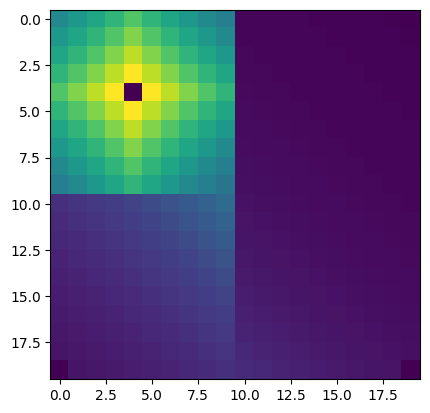

In [3]:
plt.imshow(env.state_values[:-1].reshape(20,20))

In [4]:
env.reset()
env.step(0)

(array([[[ 0,  0,  0, ...,  5,  4,  4],
         [ 0,  0,  0, ...,  5,  5,  5],
         [ 0,  0,  0, ...,  6,  6,  5],
         ...,
         [ 8,  9, 10, ..., 15, 14, 13],
         [ 7,  8,  9, ..., 14, 13, 12],
         [ 7,  8,  9, ..., 12, 12, 11]]], shape=(1, 64, 64)),
 -0.1,
 False,
 False,
 {'start_state': 255,
  'successor_state': 235,
  'state_values': -0.6531876437203107})

In [5]:
# Use a CNN to extract features from the image
feature_extractor_config = Cnn.config_cls(
    input_channels=1, 
    channels=[8,16,1], 
    kernel_sizes=[8,4,1], 
    strides=[2,2,1], 
    padding=[0,0,0],
    flatten_output=True,
    activation="silu",
    )
feature_extractor = Cnn(feature_extractor_config)
embedding_dims = feature_extractor.calculate_output_shape(input_shape=(1,64,64))[1]
print("Number of embeddind dimensions: {embedding_dims}")

# Construct the state inference model
z_dim = 8
z_layers = 4
encoder_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=z_dim * z_layers, 
    hidden_dims=embedding_dims, 
    n_layers=1, 
    )
decoder_config = Mlp.config_cls(
    input_dims=z_layers * z_dim, 
    output_dims=embedding_dims, 
    hidden_dims=embedding_dims, 
    n_layers=1, 
    )
vae_config  = DiscreteVae.config_cls(
    z_dim=z_dim, 
    z_layers=z_layers, 
    tau=1e-2, 
    beta=1.
    )
vae = DiscreteVae(
    vae_config,
    encoder=Mlp(encoder_config), 
    decoder=Mlp(decoder_config)
    )


actor_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=n_a, 
    hidden_dims=hidden_dims,
    n_layers=1, 
)
critic_config = Mlp.config_cls(
    input_dims=embedding_dims, 
    output_dims=1, 
    hidden_dims=hidden_dims, 
    n_layers=1, 
)
ac_config = ActorCritic.config_cls(
    clip_epsilon=0.2, 
    value_coeff=0.5, 
    entropy_coeff=0.01
)

model = ActorCritic(
    ac_config, 
    actor_net=Mlp(actor_config), 
    critic=Mlp(critic_config), 
    feature_extractor=feature_extractor,
    state_vae = vae,
    )


# module

Number of embeddind dimensions: {embedding_dims}


In [6]:

config = ThreadTheNeedleModule.config_class(lr=3e-4)
module = ThreadTheNeedleModule(actor_critic=model, env=env, config=config)

logger = TensorBoardLogger("../lightning_logs", name="thread_the_needle/notebook")
trainer = pl.Trainer(max_epochs=10, logger=logger)

trainer.fit(module)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type        | Params | Mode 
-----------------------------------------------------
0 | actor_critic | ActorCritic | 77.1 K | train
-----------------------------------------------------
77.1 K    Trainable params
0         Non-trainable params
77.1 K    Total params
0.309     Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode
/Users/nicholasfranklin/miniconda3/envs/vi_ppo/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/nicholasfranklin/miniconda3/envs/vi_ppo/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1

Training: |          | 0/? [00:00<?, ?it/s]

/Users/nicholasfranklin/Projects/vi_ppo/src/vi_ppo/modules.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs, dtype=torch.float32).to(self.device)
`Trainer.fit` stopped: `max_epochs=10` reached.


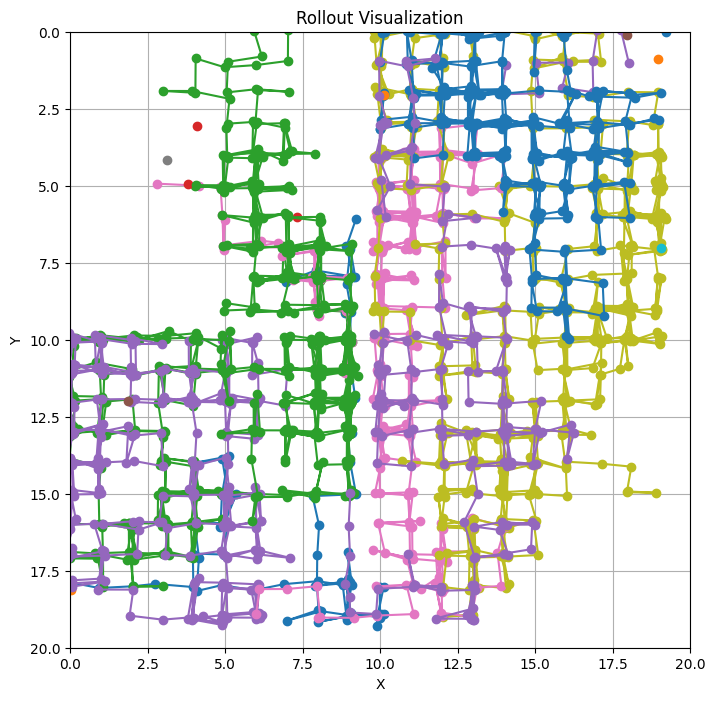

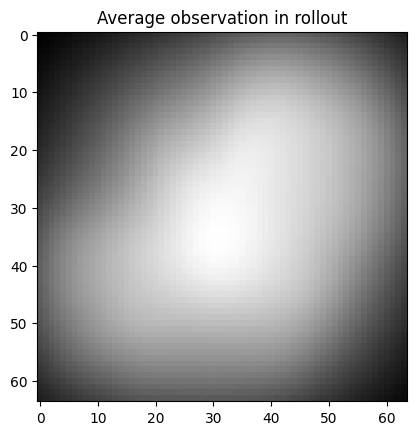

In [7]:
from vi_ppo.utils.plotting import visualize_rollout
visualize_rollout(env, module.buffer)

In [8]:
np.sum(module.buffer.terminated)

np.int64(6)

In [9]:
np.sum(module.buffer.truncated)

np.int64(6)

In [10]:
np.sum(module.buffer.rewards)

np.float64(-177.20000000000005)

In [11]:
env.end_state

[84, 399, 19, 380]

2599 tensor(0)
2600 tensor(0)
tensor(0) 2601
2602 2603
2604 tensor(0)
tensor(0) tensor(0)
2605 tensor(0)
tensor(0) 2606
2607 tensor(0)
2608 tensor(0)
2609 tensor(0)
tensor(0) 2610
2611 tensor(0)
tensor(0) tensor(0)
tensor(0) 2612
2613 tensor(0)
tensor(0) tensor(0)
2614 2615
tensor(0) tensor(0)
2616 tensor(0)
tensor(0) tensor(0)
tensor(0) 2617
tensor(0) tensor(0)
tensor(0) 2618
2619 2620
tensor(0) tensor(0)
tensor(0) tensor(0)
2621 tensor(0)
2622 tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
2623 tensor(0)
tensor(0) 2624
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) 2625
tensor(0) tensor(0)
tensor(0) 2626
tensor(0) 2627
2628 tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
2629 tensor(0)
2630 2631
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) 2632
2633 tensor(0)
tensor(0) 2634
tensor(0) 2635
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tenso

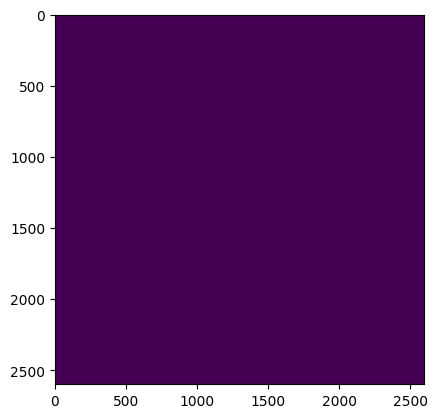

In [12]:
from vi_ppo.utils.vae import estimate_graph_laplacian
laplacian = estimate_graph_laplacian(module.actor_critic, module.buffer, normalized=False)
plt.imshow(laplacian)

In [15]:
laplacian.sum(axis=1).sum()

tensor(0.)

In [14]:
import networkx as nx

# convert the laplacian into a graph
laplacian = estimate_graph_laplacian(module.actor_critic, module.buffer, normalized=True)

edges = np.argwhere(laplacian.numpy())
edges = [(i, j) for i, j in edges if i != j]  # remove self-edges

G = nx.Graph()
G.add_edges_from(edges)
nx.draw_networkx(G, with_labels=False, node_size=5)

2586 tensor(0)
2587 2588
2589 tensor(0)
2590 2591
2592 tensor(0)
tensor(0) tensor(0)
tensor(0) 2593
tensor(0) tensor(0)
tensor(0) tensor(0)
2594 tensor(0)
tensor(0) tensor(0)
tensor(0) 2595
tensor(0) tensor(0)
2596 2597
tensor(0) 2598
2599 tensor(0)
tensor(0) 2600
tensor(0) 2601
tensor(0) 2602
2603 2604
2605 tensor(0)
tensor(0) tensor(0)
2606 2607
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
2608 tensor(0)
tensor(0) tensor(0)
2609 tensor(0)
tensor(0) 2610
tensor(0) tensor(0)
tensor(0) 2611
tensor(0) 2612
tensor(0) tensor(0)
tensor(0) 2613
2614 tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) 2615
2616 tensor(0)
tensor(0) tensor(0)
2617 2618
tensor(0) tensor(0)
2619 tensor(0)
tensor(0) tensor(0)
2620 2621
2622 tensor(0)
tensor(0) 2623
tensor(0) tensor(0)
2624 tensor(0)
tensor(0) tensor(0)
2625 2626
tensor(0) tensor(0)
2627 tensor(0)
tensor(0) 2628
2629 tensor(0)
2630 tensor(0)
tensor(0) 2631
2632 tensor(0)
2633 tensor(0)


RuntimeError: The size of tensor a (3532) must match the size of tensor b (2586) at non-singleton dimension 1